In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import statsmodels.graphics.tsaplots as sgt 
import statsmodels.tsa.stattools as sts 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats.distributions import chi2
from pmdarima.arima import auto_arima
import seaborn as sns
from statsmodels.tsa.api import ARDL
from statsmodels.tsa.ardl import ardl_select_order

sns.set_style("darkgrid")
sns.mpl.rc("figure", figsize=(16, 6))
sns.mpl.rc("font", size=14)

In [2]:
### Function to convert dataframe to timeseries object
def create_ts_object(df):
    df.Timestamp = pd.to_datetime(df.Timestamp)
    df.set_index("Timestamp", inplace=True)
    df = df.asfreq('H')

    return df.head()

### Import Total Steam data

In [3]:
TotSteamdata = pd.read_csv("~/Documents/Data/FinalDatasetForModel/Steam_to_dig_set.csv")
create_ts_object(TotSteamdata)

,steam_flowrate_to_digester_set
Timestamp,
2020-11-01 00:00:00,26.539990
2020-11-01 01:00:00,19.887745
2020-11-01 02:00:00,29.421328
2020-11-01 03:00:00,25.719750
2020-11-01 04:00:00,34.873634


### Stationarity

In [4]:
sts.adfuller(TotSteamdata)

(-9.370388142299513,
 7.404587324523095e-16,
 10,
 2198,
 {'1%': -3.4333285957162567,
  '5%': -2.8628558483095645,
  '10%': -2.5674704904367522},
 16110.428743029253)

### ACF

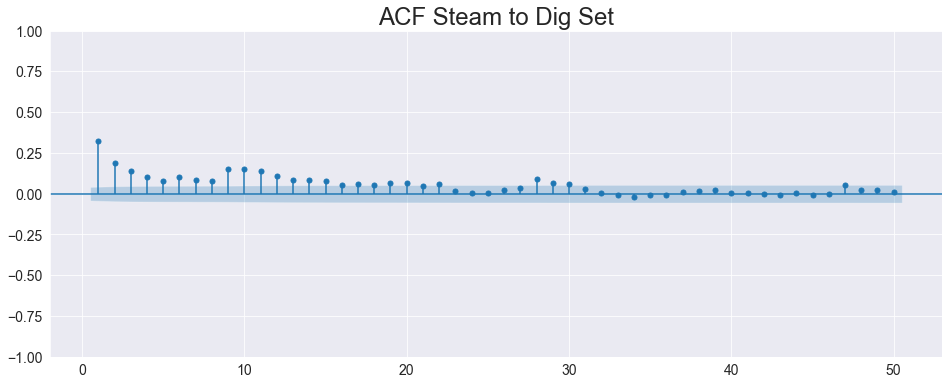

In [5]:
sgt.plot_acf(TotSteamdata, lags = 50, zero = False)
plt.title("ACF Steam to Dig Set", size = 24)
plt.show()

### PACF

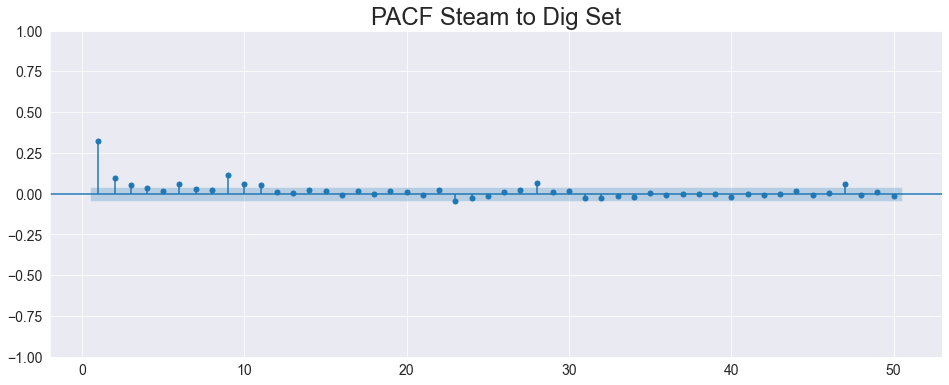

In [6]:
sgt.plot_pacf(TotSteamdata, lags = 50, zero = False, method = ('ols'))
plt.title("PACF Steam to Dig Set", size = 24)
plt.show()

In [7]:
# Spare copy
TotSteamdata_twin1 = TotSteamdata.copy()

### Normalization

In [8]:
# define functions to scale and reverse-scale data, looping through the columns, and passing a scaler type
def scale_data(data, scaler):
    for col in data.columns.values:
        data[col] = scaler.fit_transform(data[col].values.reshape(-1, 1))
    return data.head()

In [9]:
scaler = MinMaxScaler()
TotSteamdata_twin = TotSteamdata.copy()
scale_data(TotSteamdata_twin, scaler)

,steam_flowrate_to_digester_set
Timestamp,
2020-11-01 00:00:00,0.389207
2020-11-01 01:00:00,0.285744
2020-11-01 02:00:00,0.434020
2020-11-01 03:00:00,0.376450
2020-11-01 04:00:00,0.518820


### Data Split

In [10]:
train_size = int(len(TotSteamdata_twin)*0.85)
val_size = train_size + int(len(TotSteamdata_twin)*0.10)
train_TotSteam = TotSteamdata_twin.iloc[:train_size]
val_TotSteam = TotSteamdata_twin.iloc[train_size:val_size]
test_TotSteam = TotSteamdata_twin.iloc[val_size:]

### Auto ARIMA Model

In [11]:
model_auto = auto_arima(train_TotSteam, max_order = None, max_p = 30, max_q = 30,
                       maxiter = 100, alpha = 0.05, n_jobs = -1, trend = 'ct',)

C:\Users\USER\AppData\Local\Programs\Python\Python39\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


In [12]:
model_auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1877
Model:               SARIMAX(2, 0, 0)   Log Likelihood                 896.432
Date:                Tue, 15 Mar 2022   AIC                          -1782.865
Time:                        09:13:43   BIC                          -1755.177
Sample:                             0   HQIC                         -1772.666
                               - 1877                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.3339      0.014     23.913      0.000       0.307       0.361
drift       1.552e-06   6.32e-06      0.246      0.806   -1.08e-05    1.39e-05
ar.L1          0.2359      0.023     10.292      0.000       0.191       0.281
ar.L2          0.0534      0.023      2.302      0.021       0.008       0.099
sigma2         0.0225      0.001     30.921      0.000       0.021       0.024
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                14.31
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               0.96   Skew:                             0.21
Prob(H) (two-sided):                  0.60   Kurtosis:                         3.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### AR Model Residual Analysis

In [13]:
TotSteam_resid_dataset = train_TotSteam.copy()
TotSteam_resid_dataset['residuals'] = model_auto.resid()

In [14]:
print(TotSteam_resid_dataset.residuals.mean())
print(TotSteam_resid_dataset.residuals.var())

-0.00013190397180703716
0.02253814723157713


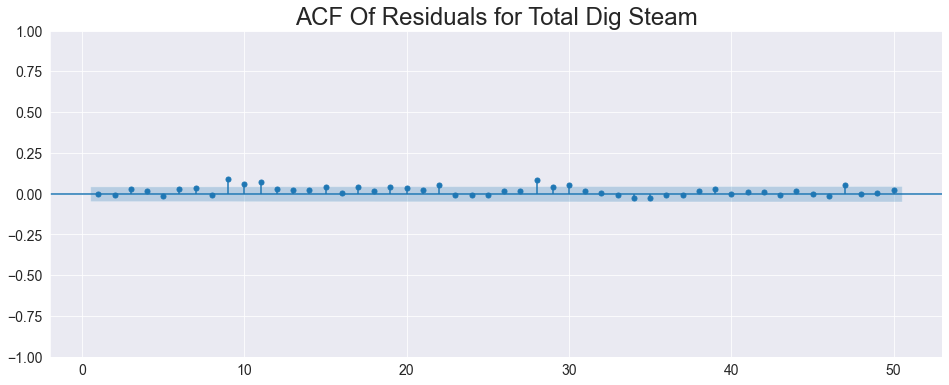

In [15]:
sgt.plot_acf(TotSteam_resid_dataset.residuals, zero = False, lags = 50)
plt.title("ACF Of Residuals for Total Dig Steam",size=24)
plt.show()

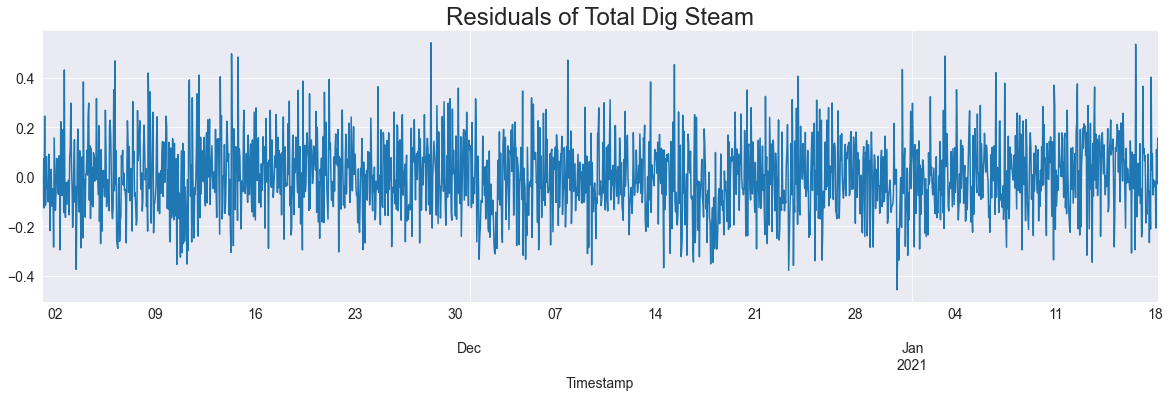

In [16]:
TotSteam_resid_dataset.residuals[1:].plot(figsize=(20,5))
plt.title("Residuals of Total Dig Steam",size=24)
plt.show()

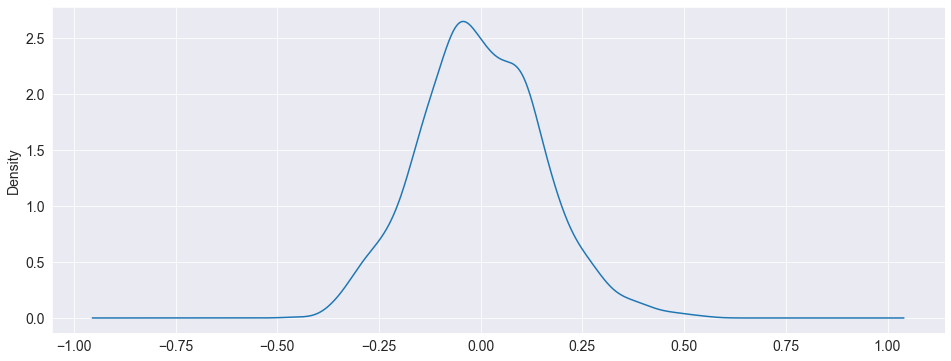

In [17]:
TotSteam_resid_dataset.residuals[1:].plot(kind='kde')
plt.show()

### Model Validation

In [18]:
start_date = "2021-01-18 05:00:00"
end_date = "2021-01-27 08:00:00"

In [19]:
df_pred = pd.DataFrame(model_auto.predict(n_periods = len(val_TotSteam),
                            index = val_TotSteam.index))

In [20]:
scaler2 = MinMaxScaler()
scaler2.fit_transform(TotSteamdata_twin1)

array([[0.38920671],
       [0.28574441],
       [0.43402012],
       ...,
       [0.40569212],
       [0.27779826],
       [0.48416885]])

In [21]:
# Invert the scale of predictions
df_pred2 = scaler2.inverse_transform(df_pred.values.reshape(-1, 1))

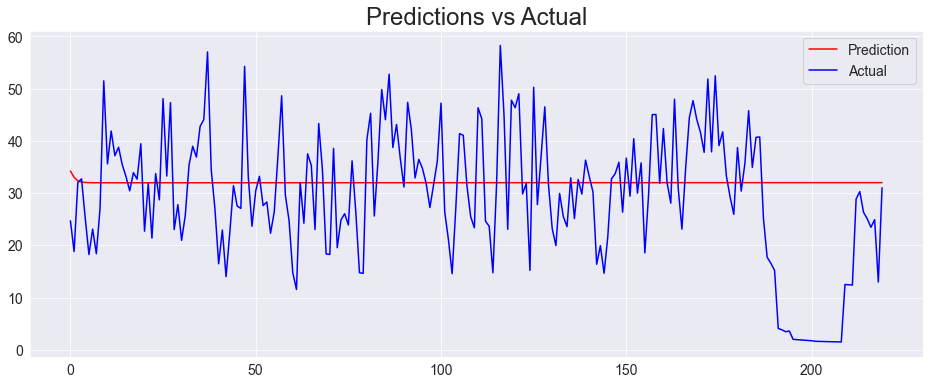

In [22]:
plt.plot(df_pred.index.to_numpy(), df_pred2, color = "red")
plt.plot(df_pred.index, TotSteamdata_twin1[start_date:end_date].to_numpy(), color = "blue")
plt.legend(['Prediction', 'Actual'])
plt.title("Predictions vs Actual", size = 24)
plt.show()

### Performance Metrics

In [23]:
ndapred, ndaactual = df_pred, val_TotSteam.to_numpy()

In [24]:
print(ndapred.shape)
print(ndaactual.shape)

(220, 1)
(220, 1)


In [25]:
print("MAE: %.4f" %mean_absolute_error(ndaactual, ndapred))
print("RMSE: %.4f" %np.sqrt(mean_squared_error(ndaactual, ndapred)))

MAE: 0.1551
RMSE: 0.2014


In [26]:
# Export np array
np.save("C:/Users/USER/Documents/PythonModels/Linear/Composite predictions/TotSteampred.npy", df_pred2)
np.save("C:/Users/USER/Documents/PythonModels/Linear/Composite predictions/TotSteam.npy", TotSteamdata_twin1[start_date:end_date].to_numpy())

### Forecast

In [27]:
fcast = pd.DataFrame(model_auto.predict(n_periods = len(test_TotSteam), index = test_TotSteam.index))

In [28]:
fcast = scaler2.inverse_transform(fcast.values.reshape(-1, 1))

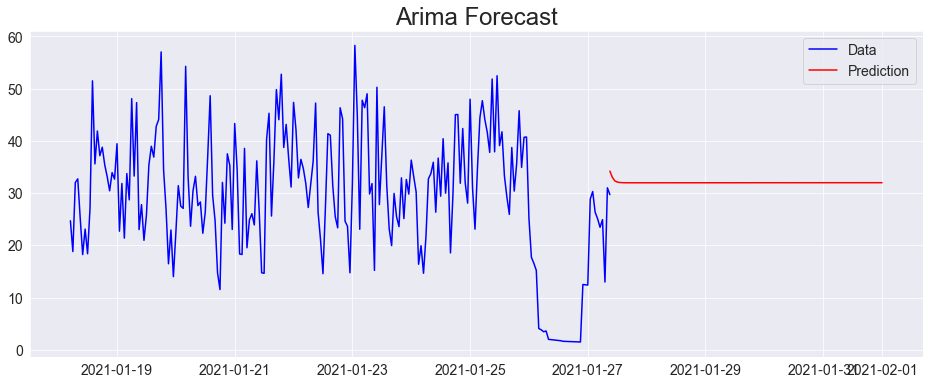

In [29]:
plt.plot(TotSteamdata_twin1.index[1877:2098], TotSteamdata_twin1[1877:2098].to_numpy(), color = "blue")
plt.plot(test_TotSteam.index, fcast, color = "red")
plt.legend(['Data', 'Prediction'])
plt.title("Arima Forecast", size = 24)
plt.show()

In [30]:
np.save("C:/Users/USER/Documents/PythonModels/Linear/Composite predictions/TotSteamfcast.npy", fcast)